In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)

2023-06-21 11:19:12.871695: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-21 11:19:13.337067: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


2.12.0


In [3]:
from eggman.grid import luminosity, log_surface_gravity, calculate_eep

In [4]:
filename = "/mnt/data-storage/yaguangli2023/stellar-models/grid_models_surface_effect_uncorrected/grid.h5"
tracks = pd.read_hdf(filename, "tracks")
tracks.head()

star_mass     Yinit     Zinit      amlt  fov_core  fov_shell
track                                                              
7000     0.92329  0.279311  0.001829  1.608258  0.000000   0.006041
7001     1.72329  0.229311  0.010871  2.308258  0.012396   0.006041
7002     2.12329  0.304311  0.004172  2.658258  0.015861   0.006041
7003     1.32329  0.254311  0.024469  1.958258  0.002481   0.006041
7004     1.12329  0.291811  0.006519  2.133258  0.000000   0.006041

In [5]:
stars = pd.read_hdf(filename, "stars")
stars.head()

star_age    radius         Teff  center_h1    log_LHe  \
track star                                                              
7000  1     2.220454e+07  0.893151  6382.509287   0.718192 -45.291905   
      2     2.300916e+07  0.891027  6377.312552   0.718122 -45.308912   
      3     2.397470e+07  0.890320  6373.785487   0.718037 -45.328570   
      4     3.019433e+07  0.893682  6371.412400   0.717474 -45.392646   
      5     3.259691e+07  0.894573  6371.453759   0.717253 -45.402736   

            log_Lnuc  Dnu_freq_o     eps_o  delta_Pg  
track star                                            
7000  1     0.078416  148.565794  1.129515       0.0  
      2     0.077135  149.148739  1.131800       0.0  
      3     0.075916  149.362908  1.132830       0.0  
      4     0.075178  148.552167  1.130613       0.0  
      5     0.075810  148.331713  1.129892       0.0

In [6]:
grid = tracks.join(stars).reset_index()
grid.head()

track  star  star_mass     Yinit     Zinit      amlt  fov_core  fov_shell  \
0   7000     1    0.92329  0.279311  0.001829  1.608258       0.0   0.006041   
1   7000     2    0.92329  0.279311  0.001829  1.608258       0.0   0.006041   
2   7000     3    0.92329  0.279311  0.001829  1.608258       0.0   0.006041   
3   7000     4    0.92329  0.279311  0.001829  1.608258       0.0   0.006041   
4   7000     5    0.92329  0.279311  0.001829  1.608258       0.0   0.006041   

       star_age    radius         Teff  center_h1    log_LHe  log_Lnuc  \
0  2.220454e+07  0.893151  6382.509287   0.718192 -45.291905  0.078416   
1  2.300916e+07  0.891027  6377.312552   0.718122 -45.308912  0.077135   
2  2.397470e+07  0.890320  6373.785487   0.718037 -45.328570  0.075916   
3  3.019433e+07  0.893682  6371.412400   0.717474 -45.392646  0.075178   
4  3.259691e+07  0.894573  6371.453759   0.717253 -45.402736  0.075810   

   Dnu_freq_o     eps_o  delta_Pg  
0  148.565794  1.129515       0.0  
1  149.148739  1.131800       0.0  
2  149.362908  1.132830       0.0  
3  148.552167  1.130613       0.0  
4  148.331713  1.129892       0.0

In [7]:
grid["log_Zinit"] = np.log10(grid.Zinit)
grid["log_age"] = np.log10(grid.star_age)

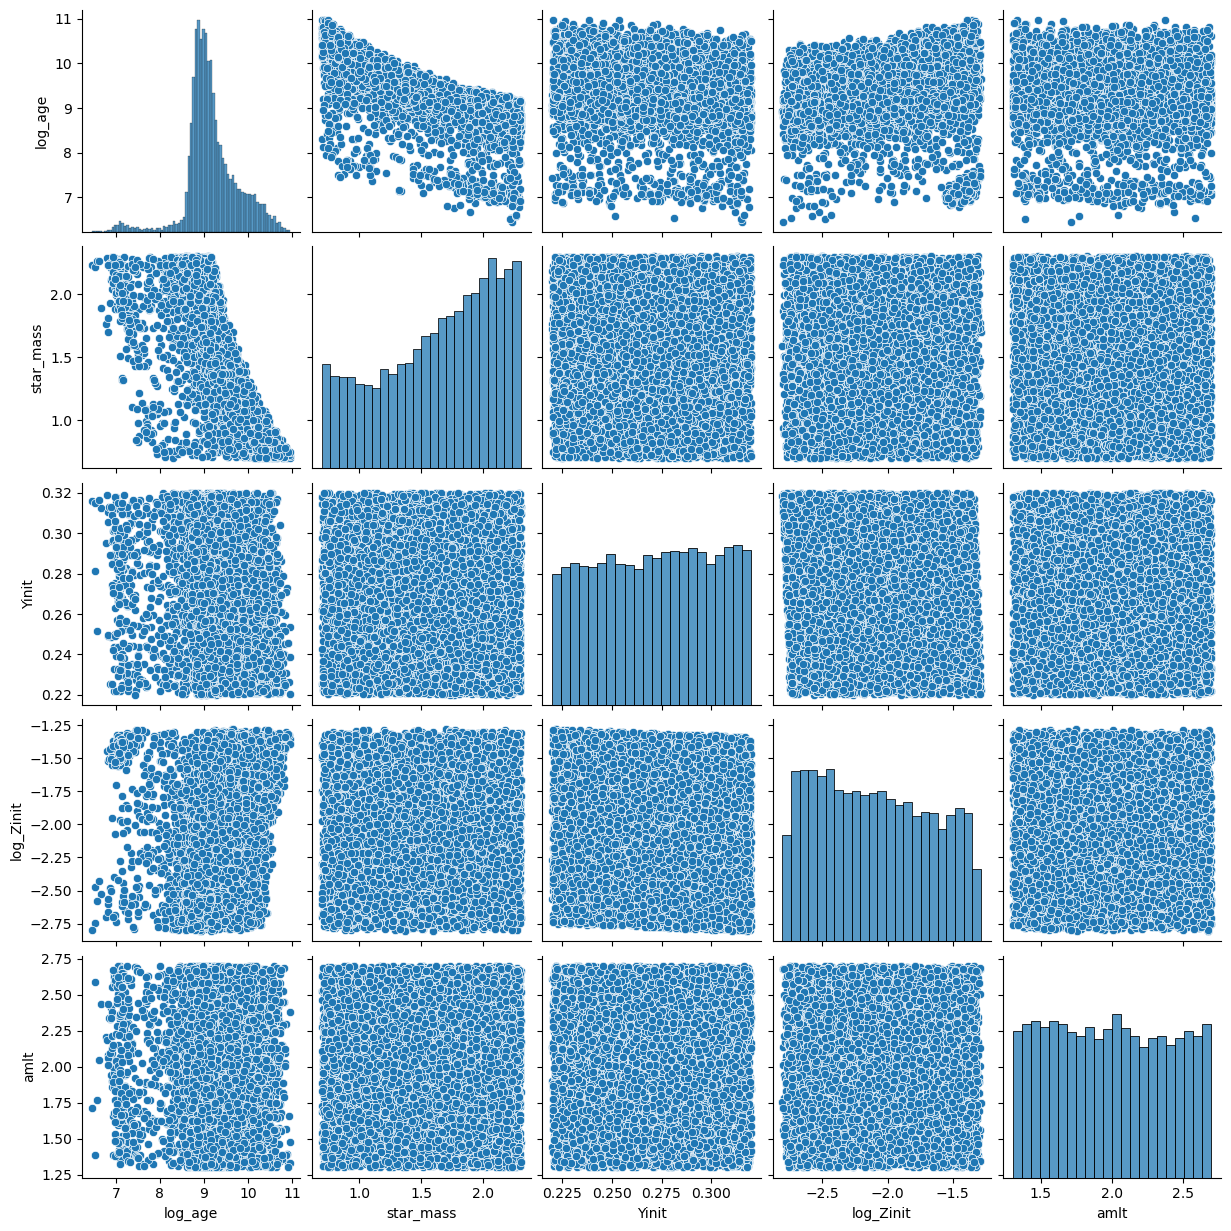

In [8]:
vars = ["log_age", "star_mass", "Yinit", "log_Zinit", "amlt"]
sns.pairplot(grid.sample(10000), vars=vars);

The data needs some cleaning, there are low age patches.

In [9]:
grid["log_Teff"] = np.log10(grid.Teff)
grid["log_R"] = np.log10(grid.radius)
grid["log_Dnu"] = np.log10(grid.Dnu_freq_o)

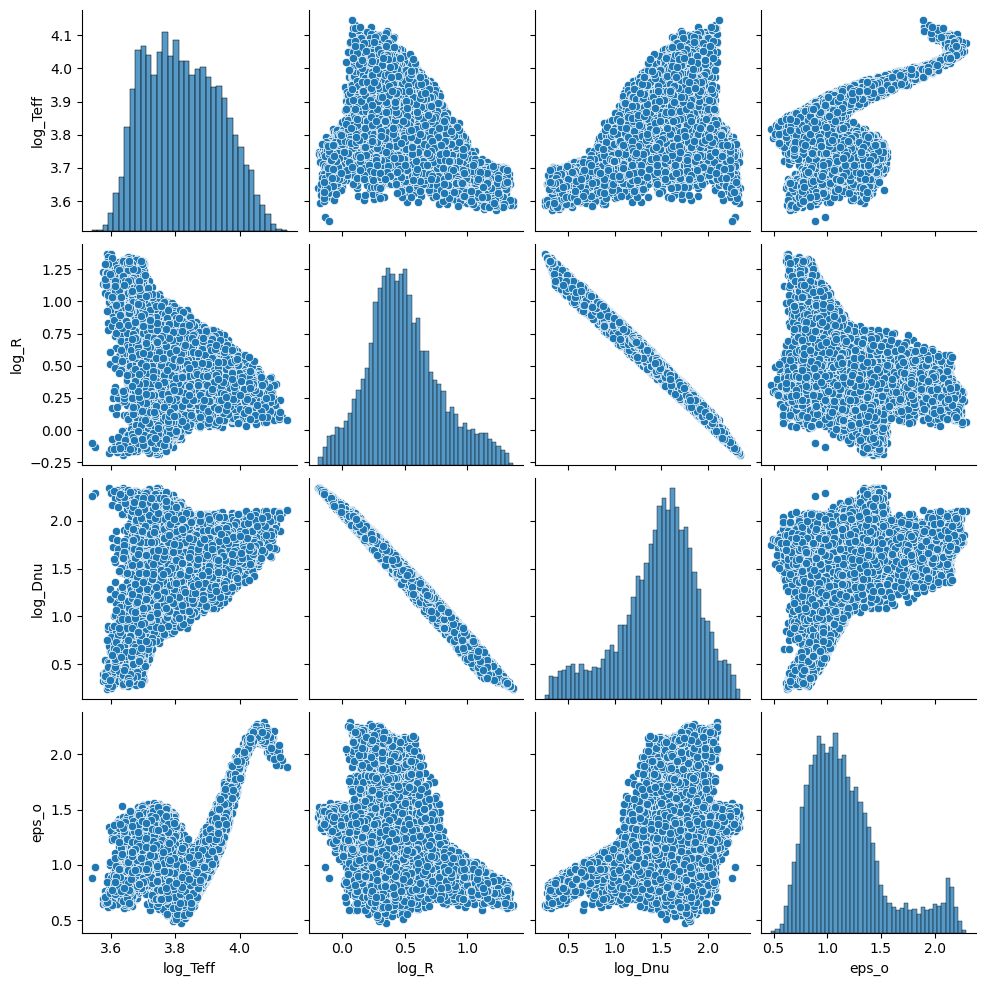

In [10]:
vars = ["log_Teff", "log_R", "log_Dnu", "eps_o"]
sns.pairplot(grid.sample(10000), vars=vars);

In [122]:
data = grid.dropna()
data.head()

track  star  star_mass     Yinit     Zinit      amlt  fov_core  fov_shell  \
0   7000     1    0.92329  0.279311  0.001829  1.608258       0.0   0.006041   
1   7000     2    0.92329  0.279311  0.001829  1.608258       0.0   0.006041   
2   7000     3    0.92329  0.279311  0.001829  1.608258       0.0   0.006041   
3   7000     4    0.92329  0.279311  0.001829  1.608258       0.0   0.006041   
4   7000     5    0.92329  0.279311  0.001829  1.608258       0.0   0.006041   

       star_age    radius  ...    log_LHe  log_Lnuc  Dnu_freq_o     eps_o  \
0  2.220454e+07  0.893151  ... -45.291905  0.078416  148.565794  1.129515   
1  2.300916e+07  0.891027  ... -45.308912  0.077135  149.148739  1.131800   
2  2.397470e+07  0.890320  ... -45.328570  0.075916  149.362908  1.132830   
3  3.019433e+07  0.893682  ... -45.392646  0.075178  148.552167  1.130613   
4  3.259691e+07  0.894573  ... -45.402736  0.075810  148.331713  1.129892   

   delta_Pg  log_Zinit   log_age  log_Teff     log_R   log_Dnu  
0       0.0  -2.737812  7.346442  3.804991 -0.049075  2.171919  
1       0.0  -2.737812  7.361901  3.804638 -0.050109  2.173620  
2       0.0  -2.737812  7.379753  3.804397 -0.050454  2.174243  
3       0.0  -2.737812  7.479925  3.804236 -0.048817  2.171879  
4       0.0  -2.737812  7.513176  3.804239 -0.048384  2.171234  

[5 rows x 22 columns]

In [123]:
data["log_g"] = log_surface_gravity(data)
data["log_L"] = np.log10(luminosity(data))

In [124]:
with open("central_hydrogen_problem_tracks.txt") as file:
    bad = list(map(int, file.read().split(",")))

In [125]:
data = data.drop(index=data[data.track.isin(bad)].index)

In [128]:
phase, _ = calculate_eep(data)
data["phase"] = phase

In [136]:
data = data.drop(index=data[data.phase == -1].index)
data

track  star  star_mass     Yinit     Zinit      amlt  fov_core  \
4         7000     5    0.92329  0.279311  0.001829  1.608258       0.0   
5         7000     6    0.92329  0.279311  0.001829  1.608258       0.0   
6         7000     7    0.92329  0.279311  0.001829  1.608258       0.0   
7         7000     8    0.92329  0.279311  0.001829  1.608258       0.0   
8         7000     9    0.92329  0.279311  0.001829  1.608258       0.0   
...        ...   ...        ...       ...       ...       ...       ...   
6587233   4999   480    0.99087  0.316689  0.036025  1.923737       0.0   
6587234   4999   481    0.99087  0.316689  0.036025  1.923737       0.0   
6587235   4999   482    0.99087  0.316689  0.036025  1.923737       0.0   
6587236   4999   483    0.99087  0.316689  0.036025  1.923737       0.0   
6587237   4999   484    0.99087  0.316689  0.036025  1.923737       0.0   

         fov_shell      star_age     radius  ...  log_Zinit    log_age  \
4         0.006041  3.259691e+07   0.894573  ...  -2.737812   7.513176   
5         0.006041  3.548000e+07   0.895385  ...  -2.737812   7.549984   
6         0.006041  4.309136e+07   0.896934  ...  -2.737812   7.634390   
7         0.006041  5.405171e+07   0.898494  ...  -2.737812   7.732809   
8         0.006041  6.983463e+07   0.900101  ...  -2.737812   7.844071   
...            ...           ...        ...  ...        ...        ...   
6587233   0.006041  1.446116e+10  11.974001  ...  -1.443394  10.160203   
6587234   0.006041  1.446395e+10  12.438793  ...  -1.443394  10.160287   
6587235   0.006041  1.446496e+10  12.619153  ...  -1.443394  10.160317   
6587236   0.006041  1.446593e+10  12.798060  ...  -1.443394  10.160346   
6587237   0.006041  1.446687e+10  12.979214  ...  -1.443394  10.160375   

         log_Teff     log_R   log_Dnu     log_g   delta_X     f_nuc  phase  \
4        3.804239 -0.048384  2.171234  4.500174  0.001608  1.002145      0   
5        3.804235 -0.047990  2.170650  4.499387  0.001875  1.001741      0   
6        3.804211 -0.047240  2.169543  4.497885  0.002592  1.001313      0   
7        3.804184 -0.046485  2.168433  4.496376  0.003644  1.000889      0   
8        3.804177 -0.045709  2.167280  4.494823  0.005195  1.000489      0   
...           ...       ...       ...       ...       ...       ...    ...   
6587233  3.622522  1.078239  0.496672  2.277606  0.647286  0.994609      3   
6587234  3.620797  1.094778  0.471924  2.244528  0.647286  0.994784      3   
6587235  3.620149  1.101030  0.462585  2.232024  0.647286  0.994722      3   
6587236  3.619526  1.107144  0.453453  2.219796  0.647286  0.994695      3   
6587237  3.618881  1.113248  0.444344  2.207588  0.647286  0.994695      3   

              EEP  
4        0.000000  
5        0.018431  
6        0.060696  
7        0.109978  
8        0.165690  
...           ...  
6587233  3.889611  
6587234  3.905807  
6587235  3.911918  
6587236  3.917889  
6587237  3.923854  

[6228873 rows x 27 columns]

In [453]:
# dist = pd.Series(np.nan, index=data.index)
eep = pd.Series(np.nan, index=data.index)

eep_keys = ["log_Teff", "log_g", "log_age"]
# eep_keys = ["log_age", "log_Teff", "log_Dnu"]
# weights = np.array([10., 1., 2.])
weights = np.ones(len(eep_keys))
alpha = 0.2

for _, group in data.groupby("track"):
    di = ((weights*group[eep_keys].diff()**2).sum(axis=1)**alpha).cumsum()
#     dist.loc[group.index] = di / di.max()
    phases = [[0], [1], [2], [3]]
    for i, p in enumerate(phases):
        idx = group[group.phase.isin(p)].index
        lower = idx[0]
        upper = group[group.phase.isin(phases[i+1])].index[0] if i+1 < len(phases) else group.index[-1]
        eep.loc[idx] = i + (di.loc[idx] - di.loc[lower]) / (di.loc[upper] - di.loc[lower])

In [454]:
data["EEP"] = eep
data["EEP"]

4          0.000000
5          0.018010
6          0.043110
7          0.069800
8          0.097832
             ...   
6587233    3.974845
6587234    3.983173
6587235    3.988817
6587236    3.994410
6587237    4.000000
Name: EEP, Length: 6228873, dtype: float64

In [455]:
rstate = 0
train = data.sample(frac=0.8, random_state=rstate)
test = data.drop(index=train.index)

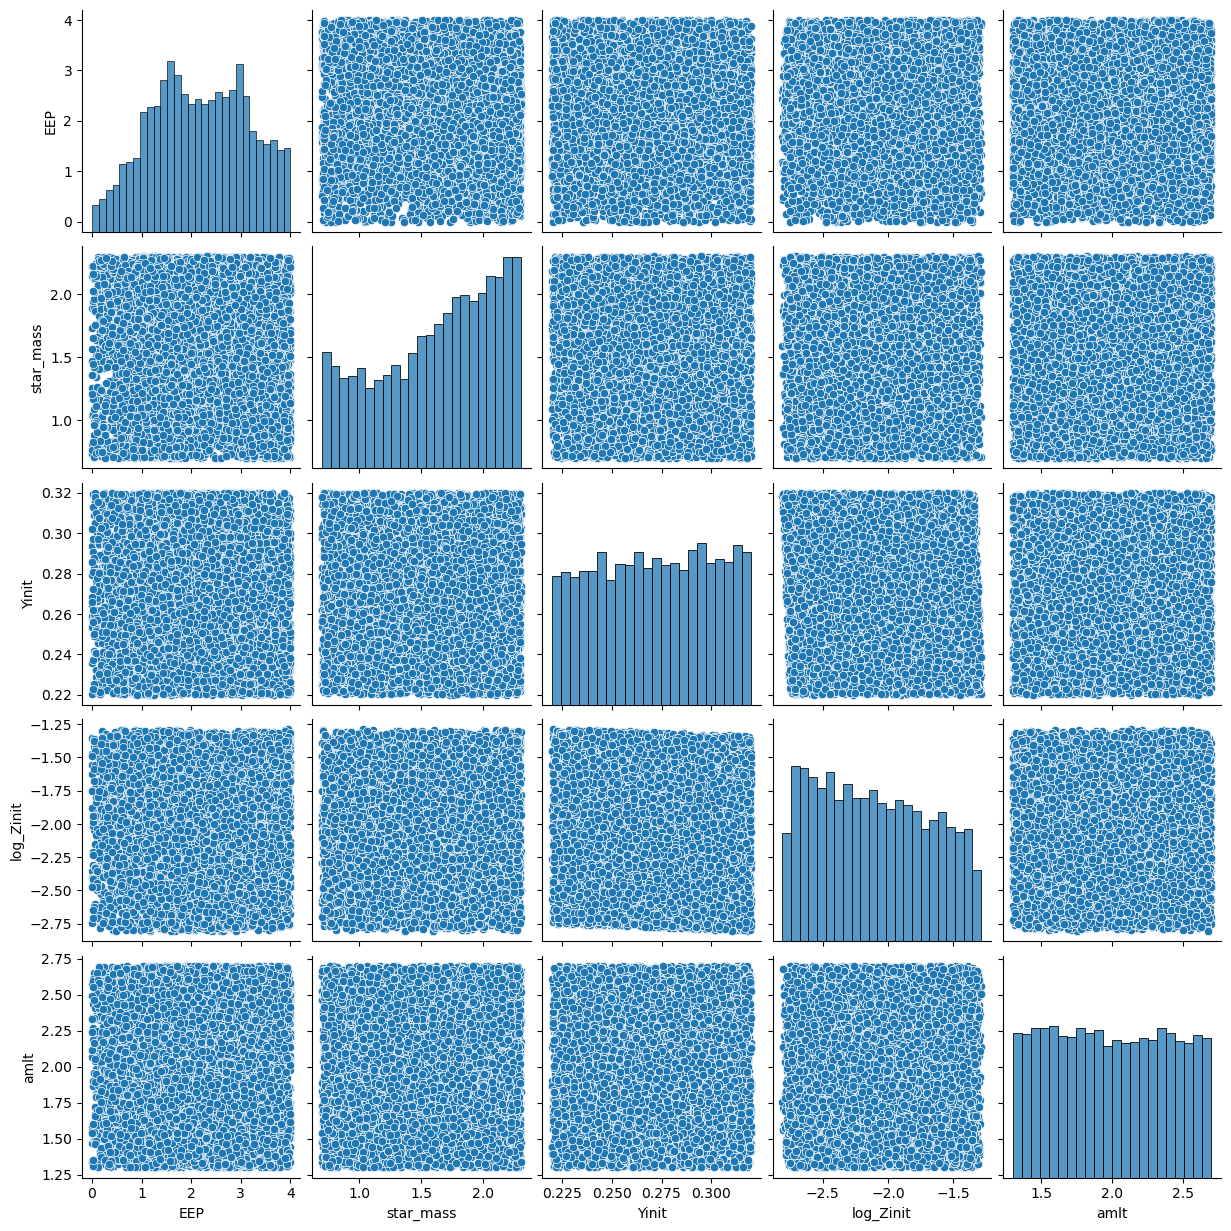

In [456]:
features = ["EEP", "star_mass", "Yinit", "log_Zinit", "amlt"]
sns.pairplot(train.sample(10000), vars=features);

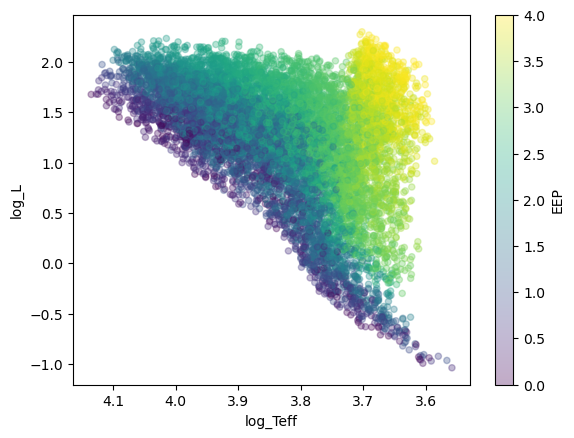

In [457]:
ax = data.sample(10000).plot(x="log_Teff", y="log_L", c="EEP", cmap="viridis", kind="scatter", alpha=0.33)
ax.invert_xaxis()

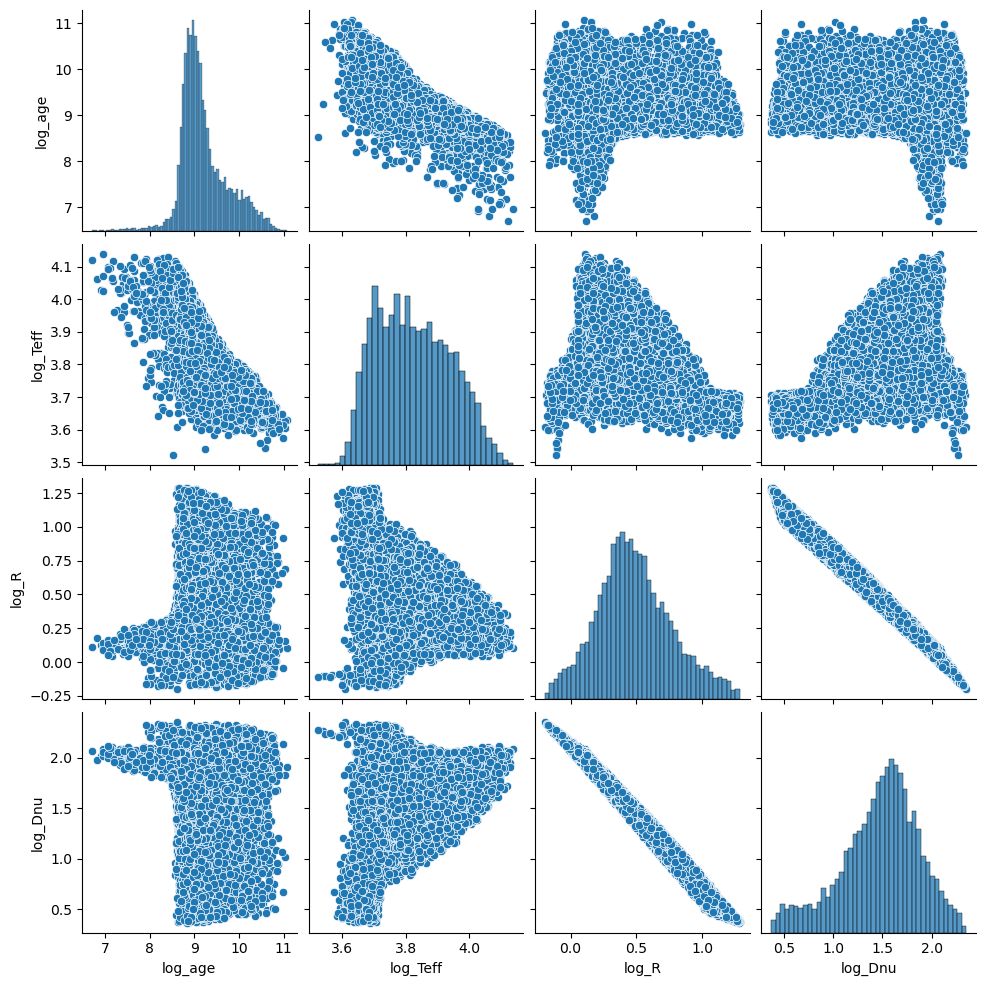

In [458]:
labels = ["log_age", "log_Teff", "log_R", "log_Dnu"]
sns.pairplot(train.sample(10000), vars=labels);

In [459]:
train_features = train[features].astype(np.float32).copy()
test_features = test[features].astype(np.float32).copy()

train_labels = train[labels].astype(np.float32).copy()
test_labels = test[labels].astype(np.float32).copy()

In [460]:
normalizer = layers.Normalization(axis=-1)

In [461]:
normalizer.adapt(np.array(train_features), batch_size=len(train_features))
print(normalizer.mean.numpy())

[[ 2.1462443   1.6388708   0.27121973 -2.108368    1.9911563 ]]


In [462]:
label_offset = train_labels.mean().to_numpy()
label_scale = train_labels.std().to_numpy()

rescaler = layers.Rescaling(label_scale, offset=label_offset)

In [463]:
activation = "relu"
arch = (6, 128)

model = tf.keras.Sequential(
    [normalizer] +
    [layers.Dense(arch[1], activation) for _ in range(arch[0])] +
    [layers.Dense(len(labels)), rescaler]
)

In [464]:
model.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_12 (Normaliza  (None, 5)                11        
 tion)                                                           
                                                                 
 dense_98 (Dense)            (None, 128)               768       
                                                                 
 dense_99 (Dense)            (None, 128)               16512     
                                                                 
 dense_100 (Dense)           (None, 128)               16512     
                                                                 
 dense_101 (Dense)           (None, 128)               16512     
                                                                 
 dense_102 (Dense)           (None, 128)               16512     
                                                     

In [465]:
learning_rate = 1e-4
beta_1 = 0.9
beta_2 = 0.999
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate, beta_1=beta_1, beta_2=beta_2)

loss = 'mean_squared_error'

model.compile(
    optimizer,
    loss=loss
)

In [466]:
epochs = 50
batch_size = 4096

In [467]:
%%time
history = model.fit(
    train_features,
    train_labels,
    epochs=epochs,
    batch_size=batch_size,
    # Suppress logging.
#     verbose=0,
    # Calculate validation results on 20% of the training data.
    validation_split = 0.2
)

Epoch 1/50
974/974 [==============================] - 5s 4ms/step - loss: 0.0113 - val_loss: 8.8709e-04
Epoch 2/50
974/974 [==============================] - 4s 4ms/step - loss: 5.6897e-04 - val_loss: 3.9367e-04
Epoch 3/50
974/974 [==============================] - 3s 4ms/step - loss: 3.1453e-04 - val_loss: 2.6733e-04
Epoch 4/50
974/974 [==============================] - 4s 4ms/step - loss: 2.2800e-04 - val_loss: 2.1736e-04
Epoch 5/50
974/974 [==============================] - 3s 4ms/step - loss: 1.9021e-04 - val_loss: 1.8610e-04
Epoch 6/50
974/974 [==============================] - 3s 4ms/step - loss: 1.6908e-04 - val_loss: 1.7008e-04
Epoch 7/50
974/974 [==============================] - 3s 4ms/step - loss: 1.5339e-04 - val_loss: 1.5065e-04
Epoch 8/50
974/974 [==============================] - 4s 4ms/step - loss: 1.4179e-04 - val_loss: 1.7717e-04
Epoch 9/50
974/974 [==============================] - 4s 4ms/step - loss: 1.3310e-04 - val_loss: 1.2961e-04
Epoch 10/50
974/974 [===========

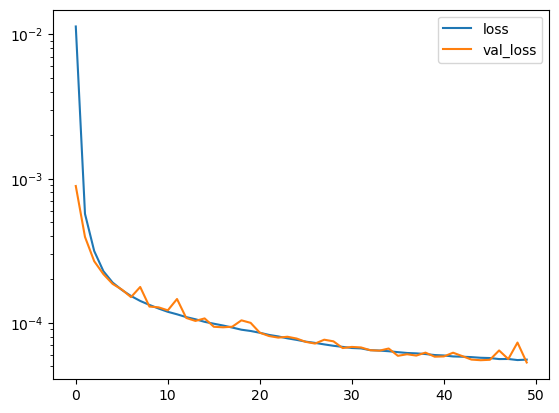

In [468]:
fig, ax = plt.subplots()

ax.plot(history.history['loss'], label='loss')
ax.plot(history.history['val_loss'], label='val_loss')
ax.legend()
ax.set_yscale("log")

In [469]:
model.predict(train_features.iloc[:2])

1/1 [==============================] - 0s 42ms/step


array([[ 9.6243477e+00,  3.7556312e+00,  3.9483035e-01,  1.5809487e+00],
       [ 9.5487547e+00,  3.7954717e+00, -8.7013543e-03,  2.1163476e+00]],
      dtype=float32)

In [470]:
train_labels.iloc[:2]

log_age  log_Teff     log_R   log_Dnu
4239372  9.623608  3.756668  0.397768  1.577576
4364990  9.552631  3.795451 -0.006648  2.109143

In [471]:
train_pred = model(train_features)

In [472]:
log_error = train_labels - train_pred.numpy()

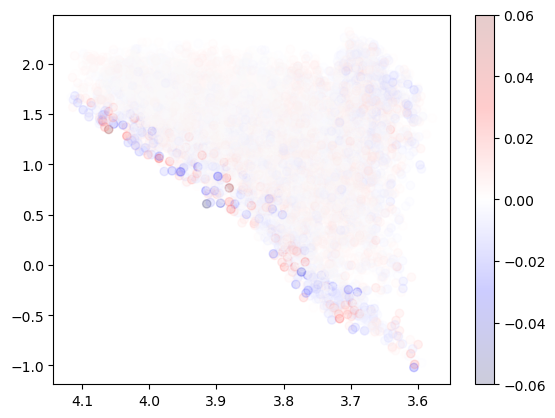

In [473]:
sample = train_labels.sample(10000)
fig, ax = plt.subplots()
s = ax.scatter(sample.log_Teff, data.loc[sample.index, "log_L"], c=log_error.loc[sample.index].mean(axis=1), 
               cmap="seismic", alpha=0.2, vmin=-0.06, vmax=0.06)
fig.colorbar(s)

ax.invert_xaxis()

In [474]:
mse = ((train_labels - train_pred.numpy())**2).mean(axis=1)

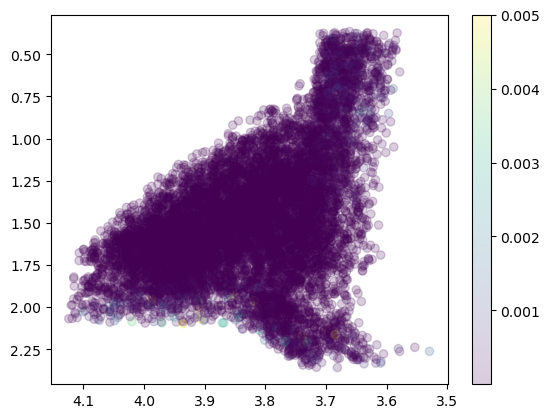

In [475]:
sample = train_labels.sample(10000)
fig, ax = plt.subplots()
s = ax.scatter(sample.log_Teff, sample.log_Dnu, c=mse.loc[sample.index], alpha=0.2, vmax=0.005)
fig.colorbar(s)

ax.invert_xaxis()
ax.invert_yaxis()

In [476]:
error = 10**train_labels - 10**train_pred.numpy()
error

log_age   log_Teff     log_R   log_Dnu
4239372   -6623488.0  12.766602  0.018054 -0.301975
4364990   33416192.0  -1.491211  0.004481 -2.091827
3633770   -2837120.0  46.314453 -0.066987  1.717865
5992731    3751040.0  -3.584473 -0.025320  0.172656
3832114    2052608.0  50.390625 -0.013882  0.233032
...              ...        ...       ...       ...
2159277   23168768.0  19.130371 -0.032932  0.038565
241230     9419008.0   0.989258 -0.004947 -0.010637
5052492     939520.0   9.261230 -0.127439  0.072516
2324695    5612128.0  -0.744141  0.018095 -0.961098
314204  -178644992.0  -0.092773  0.001047  0.401535

[4983098 rows x 4 columns]

In [479]:
error.mean()

log_age    -2.170244e+06
log_Teff    4.837870e+00
log_R      -1.080518e-03
log_Dnu     1.672848e-01
dtype: float32

In [480]:
error.std()

log_age     1.927777e+08
log_Teff    4.001004e+01
log_R       1.034332e-01
log_Dnu     6.383372e-01
dtype: float32

In [432]:
log_error

log_age  log_Teff     log_R   log_Dnu
4239372  0.006035  0.003570 -0.003688  0.001246
4364990  0.022470  0.000481  0.006229 -0.008794
3633770  0.000424 -0.003157 -0.003998  0.008458
5992731  0.003404  0.001161  0.003411 -0.002751
3832114  0.004010 -0.000813  0.000561 -0.000531
...           ...       ...       ...       ...
2159277  0.004809 -0.000278 -0.005931  0.007325
241230   0.000040 -0.001985  0.001643 -0.002720
5052492  0.003478  0.002402 -0.009519  0.012097
2324695  0.009251 -0.002019  0.002144 -0.002048
314204  -0.002756 -0.002074  0.007076 -0.010315

[4983098 rows x 4 columns]